<a href="https://colab.research.google.com/github/ikanx101/Workshop-Astra-Financial/blob/main/Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisa Data Transaksi**

Pada _workshop_ kali ini, kami akan memberikan contoh data transaksi yang didapatkan dari sistem CRM suatu minimarket di kota tertentu sejak bulan Januari 2020 hingga April 2020. Minimarket tersebut sudah terbiasa melakukan evaluasi performa setiap _quarter_.

Kita akan membuat dua analisa sederhana dari data ini, yakni:

- _Clustering_ pelanggan yang menjadi _member_.
- Membuat promo produk _bundling_.

Untuk melakukan analisa, akan ada empat tahap pengerjaan, yakni:

1. _Pre processing_ dengan menggabungkan empat data transaksi bulanan menjadi satu _dataframe_.
1. _Exploratory data analysis_ dengan membuat tabulasi dan visualisasi sederhana dari data tersebut.
1. _Clustering_ konsumen berdasarkan _framework_ __RFM__ (_retention_, _frequency_, dan _monetary_) dari masing-masing konsumen. Kelak akan didiskusikan strategi / _campaign marketing_ apa saja yang bisa kita berikan kepada masing-masing _cluster_ (kelompok) konsumen.
1. _Cross basket analysis_ untuk menganalisa dan memberikan saran produk apa saja yang bisa dijual berbarengan (_cross selling_ / _upselling_). Kita akan diskusikan juga nanti saat _workshop_.

## **Tahap I** _Pre Processing_

Pada tahap ini, kita akan _import_ semua data transaksi bulanan (format `.csv`) ke dalam _computing environment_).

In [228]:
# Menghapus semua objek dari lingkungan saat ini
rm(list=ls())
# Memanggil garbage collector untuk mengklaim kembali memori yang tidak terpakai
gc()
set.seed(17081945)

# memanggil semua libraries yang diperlukan
# dplyr: menyediakan fungsi-fungsi untuk manipulasi data (e.g., filter, select, mutate).
library(dplyr)
# tidyr: menyediakan fungsi-fungsi untuk merapikan data (e.g., gather, spread).
library(tidyr)
# janitor: library untuk memberishkan data dan membuat tabulasi sederhana
# install.packages("janitor")
library(janitor)
# ggplot2: membuat visualisasi data
library(ggplot2)
# untuk clustering
library(cluster)
# untuk clustering
# install.packages("factoextra")
library(factoextra)


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1447085,77.3,3814441,203.8,3814441,203.8
Vcells,2666512,20.4,10146329,77.5,10145632,77.5


In [229]:
# kita akan panggil semua data csv transaksi per bulan
df_1 = read.csv("jan 2020.csv")
df_2 = read.csv("feb 2020.csv")
df_3 = read.csv("mar 2020.csv")
df_4 = read.csv("apr 2020.csv")

# Menggabungkan semua data transaksi
df_all =
  data.table::rbindlist(list(df_1,df_2,df_3,df_4)) |>  # Menggabungkan data frame menggunakan rbindlist
  as.data.frame() |>  # Mengubah hasil rbindlist menjadi data frame
  select(-id) |> # Menghapus kolom X dan id
  mutate(tanggal = as.Date(tanggal,"%Y-%m-%d")) |> # Mengubah kolom tanggal menjadi tipe data Date
  mutate(bulan = months(tanggal)) |> # Membuat kolom baru "bulan" berdasarkan nilai kolom "tanggal"
  mutate(bulan = factor(bulan,levels = c("January","February","March","April"))) |> # membuat nama bulan jadi factor
  select(id_transaksi,tanggal,bulan,hari,jam,ampm,id_pelanggan,sku,qty,unit,harga,diskon,total_harga) # Memilih kolom-kolom yang ingin disertakan dalam data frame akhir

In [230]:
# Melihat struktur data frame df_all
df_all |> str()

'data.frame':	34436 obs. of  13 variables:
 $ id_transaksi: chr  "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00010/KSR/UTM/0120" ...
 $ tanggal     : Date, format: "2020-01-02" "2020-01-02" ...
 $ bulan       : Factor w/ 4 levels "January","February",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ hari        : chr  "4 Kamis" "4 Kamis" "4 Kamis" "4 Kamis" ...
 $ jam         : int  8 8 8 9 9 9 9 9 9 9 ...
 $ ampm        : chr  "1 pagi" "1 pagi" "1 pagi" "1 pagi" ...
 $ id_pelanggan: chr  "UMUM" "UMUM" "UMUM" "17114227" ...
 $ sku         : chr  "KOPIKO COFFE LATTE 240 ML" "INDOMIE GORENG 85G" "INDOMIE GORENG SPECIAL JUMBO 125 GR" "212 AIR MINERAL 48 X 240 ML" ...
 $ qty         : int  1 1 1 4 4 1 1 1 2 1 ...
 $ unit        : chr  "PCS" "PCS" "PCS" "DUS" ...
 $ harga       : num  5400 2500 3500 22000 64000 11200 10600 6700 3700 11300 ...
 $ diskon      : num  0 0 0 0 3.44 ...
 $ total_harga : num  5400 2500 3500 88000 247200 ...


Berikut adalah penjelasan beberapa variabel dari data yang sudah digabung:

- `id_transaksi`: __id__ dari satu transaksi.
- `tanggal`: tanggal transaksi.
- `id_pelanggan`: merupakan __id__ pelanggan. Pelanggan yang menjadi _member_ akan ditulis nomor _membership_-nya. Sedangkan pelanggan yang _non member_ ditulis sebagai __UMUM__.
- `sku`: merupakan nama produk yang dibeli.
- `diskon`: merupakan diskon produk dalam __persentase__.
- `total_harga`: merupakan harga total per `sku` yang merupakan perkalian dari `qty` dengan `harga` setelah dikurang `diskon`.

## **Tahap II** _Exploratory Data Analysis_

Sekarang kita akan buat EDA sederhana dari data gabungan yang ada.

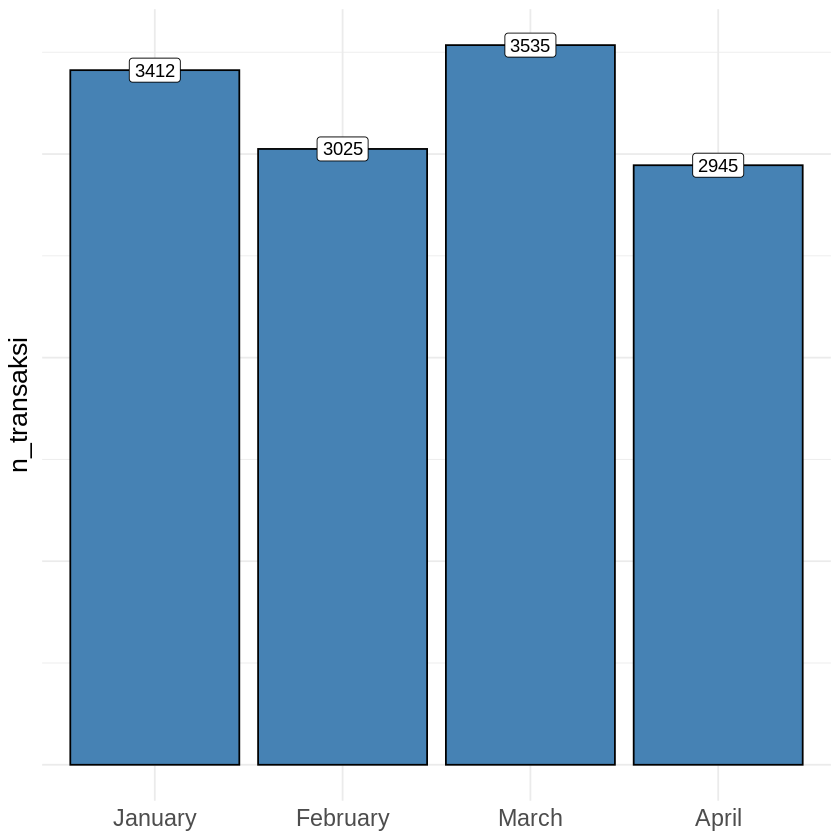

In [231]:
# perhitungan berapa banyak transaksi per bulan
df_all |>
  group_by(bulan) |>
  summarise(n_transaksi = length(unique(id_transaksi))) |>
  ungroup() |>
  ggplot(aes(x = bulan,y = n_transaksi)) +
  geom_col(color = "black",fill = "steelblue") +
  geom_label(aes(label = n_transaksi)) +
  theme_minimal() +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 14))

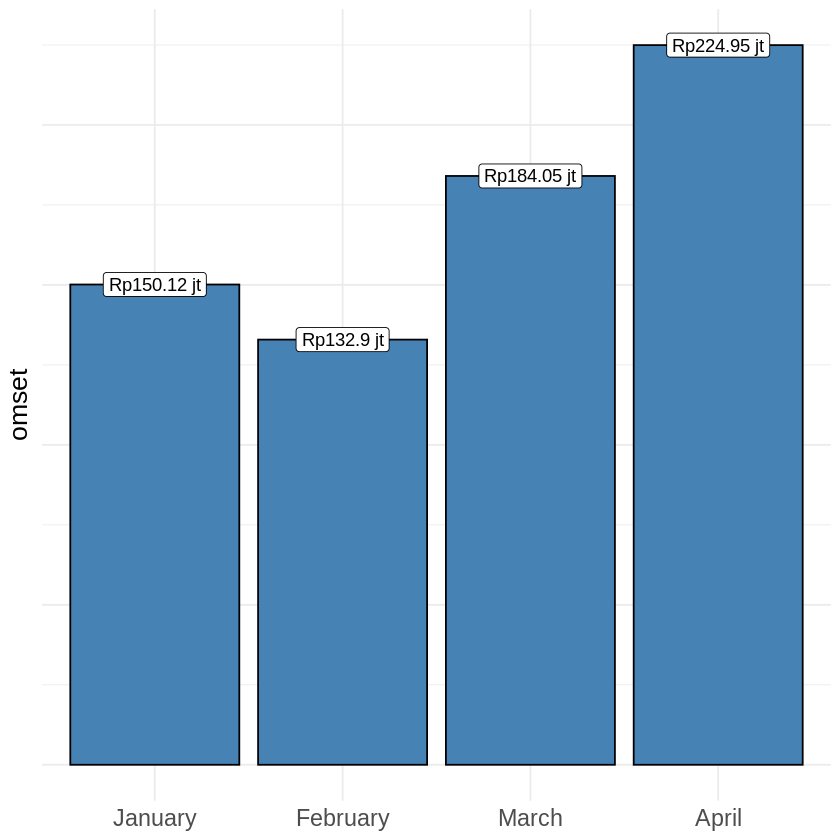

In [232]:
# perhitungan berapa besar omset per bulan
df_all |>
  group_by(bulan) |>
  summarise(omset = sum(total_harga)) |>
  ungroup() |>
  mutate(label = omset / 1000000,
         label = round(label,2),
         label = paste0("Rp",label," jt")) |>
  ggplot(aes(x = bulan,y = omset)) +
  geom_col(color = "black",fill = "steelblue") +
  geom_label(aes(label = label)) +
  theme_minimal() +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 14))

`summarise()` has grouped output by 'hari'. You can override using the
`.groups` argument.


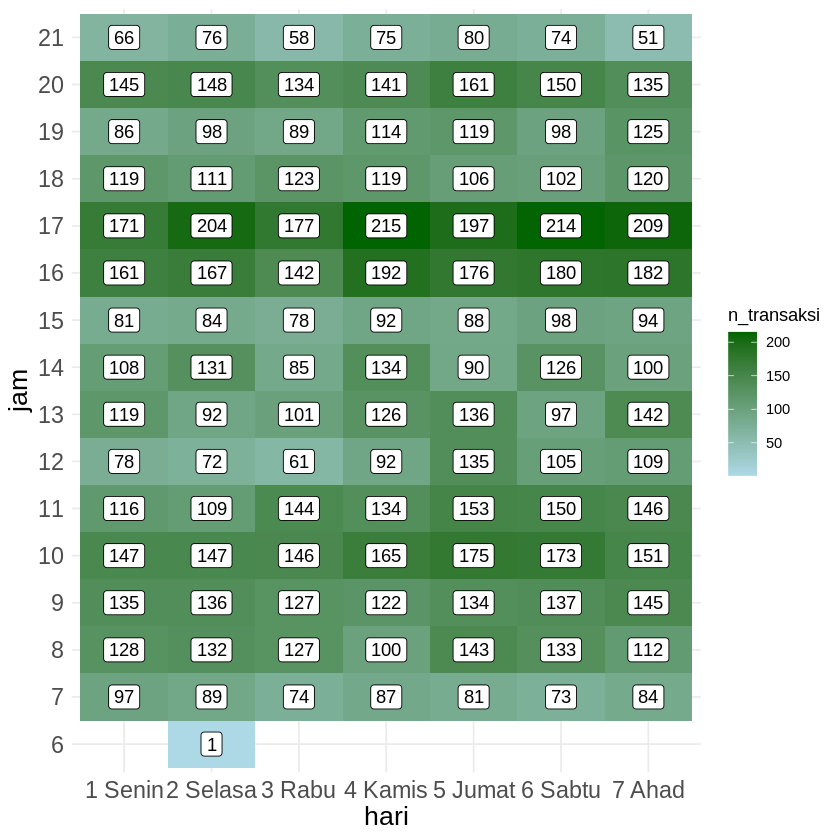

In [233]:
# waktu paling ramai di minimarket
df_all |>
  group_by(hari,jam) |>
  summarise(n_transaksi = length(unique(id_transaksi))) |>
  ungroup() |>
  mutate(jam = factor(jam)) |>
  ggplot(aes(x = hari,y = jam)) +
  geom_tile(aes(fill = n_transaksi)) +
  scale_fill_gradient(high = "darkgreen",low = "lightblue") +
  geom_label(aes(label = n_transaksi)) +
  theme_minimal() +
  theme(axis.title = element_text(size = 16),
        axis.text  = element_text(size = 14))

Selain tiga grafik di atas, EDA apa lagi yang bisa kita lakukan? Silakan buat sebagai bahan latihan.

## **Tahap III** _Clustering Analysis_ berdasarkan RFM

Pada analisa ini, __kita hanya akan memakai data transaksi dari pelanggan yang menjadi__ ___member___. Sehingga akan ada proses _filtering_ data.

__Definisi:__

- _Retention_ adalah kapan terakhir kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Frequency_ adalah berapa kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Monetary_ adalah seberapa besar (secara _value_ rupiah) pelanggan berbelanja pada rentang Januari 2020 sampai April 2020.

Kita akan menghitung ketiga parameter tersebut dengan aturan sebagai berikut:

1. Semua parameter memiliki nilai skala 1-4 (paling rendah ke paling tinggi).
1. _Retention_: pelanggan yang terakhir kali membeli pada:
    - _April_ mendapat skor 4.
    - _March_ mendapat skor 3.
    - _February_ mendapat skor 2.
    - _January_ mendapat skor 1.
1. _Frequency_: kita akan hitung rata-rata transaksi bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.
1. Monetary: Kita akan hitung rata-rata belanja bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.

In [234]:
df_all |> str()

'data.frame':	34436 obs. of  13 variables:
 $ id_transaksi: chr  "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00010/KSR/UTM/0120" ...
 $ tanggal     : Date, format: "2020-01-02" "2020-01-02" ...
 $ bulan       : Factor w/ 4 levels "January","February",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ hari        : chr  "4 Kamis" "4 Kamis" "4 Kamis" "4 Kamis" ...
 $ jam         : int  8 8 8 9 9 9 9 9 9 9 ...
 $ ampm        : chr  "1 pagi" "1 pagi" "1 pagi" "1 pagi" ...
 $ id_pelanggan: chr  "UMUM" "UMUM" "UMUM" "17114227" ...
 $ sku         : chr  "KOPIKO COFFE LATTE 240 ML" "INDOMIE GORENG 85G" "INDOMIE GORENG SPECIAL JUMBO 125 GR" "212 AIR MINERAL 48 X 240 ML" ...
 $ qty         : int  1 1 1 4 4 1 1 1 2 1 ...
 $ unit        : chr  "PCS" "PCS" "PCS" "DUS" ...
 $ harga       : num  5400 2500 3500 22000 64000 11200 10600 6700 3700 11300 ...
 $ diskon      : num  0 0 0 0 3.44 ...
 $ total_harga : num  5400 2500 3500 88000 247200 ...


In [235]:
# mengambil data yang khusus untuk RFM
# Memfilter data df_all untuk hanya menyertakan pelanggan yang merupakan member (id_pelanggan != "UMUM")
df_rfm =
  df_all |>
  filter(id_pelanggan != "UMUM")

# perhitungan retention
# Menghitung skor retention berdasarkan bulan terakhir transaksi
df_rfm_1 =
  df_rfm |>
  # Membuat kolom baru 'retention' dengan skor 1-4 berdasarkan bulan transaksi
  mutate(retention = case_when(
    bulan == "January" ~ 1, # Jika bulan transaksi Januari, skor retention = 1
    bulan == "February" ~ 2, # Jika bulan transaksi Februari, skor retention = 2
    bulan == "March" ~ 3, # Jika bulan transaksi Maret, skor retention = 3
    bulan == "April" ~ 4 # Jika bulan transaksi April, skor retention = 4
  )) |>
  # Memilih kolom id_pelanggan dan retention
  select(id_pelanggan,retention) |>
  # Menghapus baris duplikat berdasarkan kombinasi id_pelanggan dan retention
  distinct() |>
  # Mengelompokkan data berdasarkan id_pelanggan
  group_by(id_pelanggan) |>
  # Memfilter data untuk setiap pelanggan, hanya mempertahankan baris dengan skor retention tertinggi
  filter(retention == max(retention)) |>
  # Menghilangkan pengelompokan
  ungroup()


# perhitungan frekuensi
# Menghitung frekuensi transaksi per pelanggan
df_rfm_2 =
  df_rfm |>
  # Mengelompokkan data berdasarkan id_pelanggan
  group_by(id_pelanggan) |>
  # Menghitung jumlah transaksi unik per pelanggan dan menyimpannya di kolom 'freq'
  summarise(freq = length(unique(id_transaksi))) |>
  # Menghilangkan pengelompokan
  ungroup() |>
  # Menghitung rata-rata frekuensi transaksi bulanan dengan membagi 'freq' dengan 4 (jumlah bulan)
  mutate(freq = freq / 4) |>
  # Memilih kolom id_pelanggan dan freq
  select(id_pelanggan,freq) |>
  mutate(freq = cut(freq,4,labels = 1:4),
         freq = as.numeric(freq))

# perhitungan monetary
# Menghitung total nilai transaksi (monetary) per pelanggan
df_rfm_3 =
  df_rfm |>
  # Mengelompokkan data berdasarkan id_pelanggan
  group_by(id_pelanggan) |>
  # Menghitung total nilai transaksi per pelanggan dan menyimpannya di kolom 'monetary'
  summarise(monetary = sum(total_harga)) |>
  # Menghilangkan pengelompokan
  ungroup() |>
  # Menghitung rata-rata nilai transaksi bulanan dengan membagi 'monetary' dengan 4 (jumlah bulan)
  mutate(monetary = monetary / 4) |>
  # Memilih kolom id_pelanggan dan monetary
  select(id_pelanggan,monetary) |>
  mutate(monetary = cut(monetary,4,labels = 1:4),
         monetary = as.numeric(monetary))

# Menampilkan struktur data dari df_rfm_1, df_rfm_2, dan df_rfm_3
str(df_rfm_1)
str(df_rfm_2)
str(df_rfm_3)

# Menggabungkan data frame df_rfm_1, df_rfm_2, dan df_rfm_3 menjadi satu data frame df_rfm_all
df_rfm_all =
  merge(df_rfm_1,df_rfm_2) |> # Menggabungkan df_rfm_1 dan df_rfm_2 berdasarkan kolom 'id_pelanggan'
  merge(df_rfm_3) # Menggabungkan hasil penggabungan sebelumnya dengan df_rfm_3 berdasarkan kolom 'id_pelanggan'

# Menskalakan data RFM menggunakan fungsi scale()
df_rfm_all_scaled = df_rfm_all |> select(-id_pelanggan)

tibble [131 × 2] (S3: tbl_df/tbl/data.frame)
 $ id_pelanggan: chr [1:131] "17114230" "17114135" "17114011" "17114104" ...
 $ retention   : num [1:131] 1 2 2 2 2 2 2 2 2 3 ...
tibble [131 × 2] (S3: tbl_df/tbl/data.frame)
 $ id_pelanggan: chr [1:131] "17114001" "17114002" "17114003" "17114004" ...
 $ freq        : num [1:131] 1 1 2 1 1 1 1 1 1 1 ...
tibble [131 × 2] (S3: tbl_df/tbl/data.frame)
 $ id_pelanggan: chr [1:131] "17114001" "17114002" "17114003" "17114004" ...
 $ monetary    : num [1:131] 1 1 2 1 1 1 1 1 1 1 ...


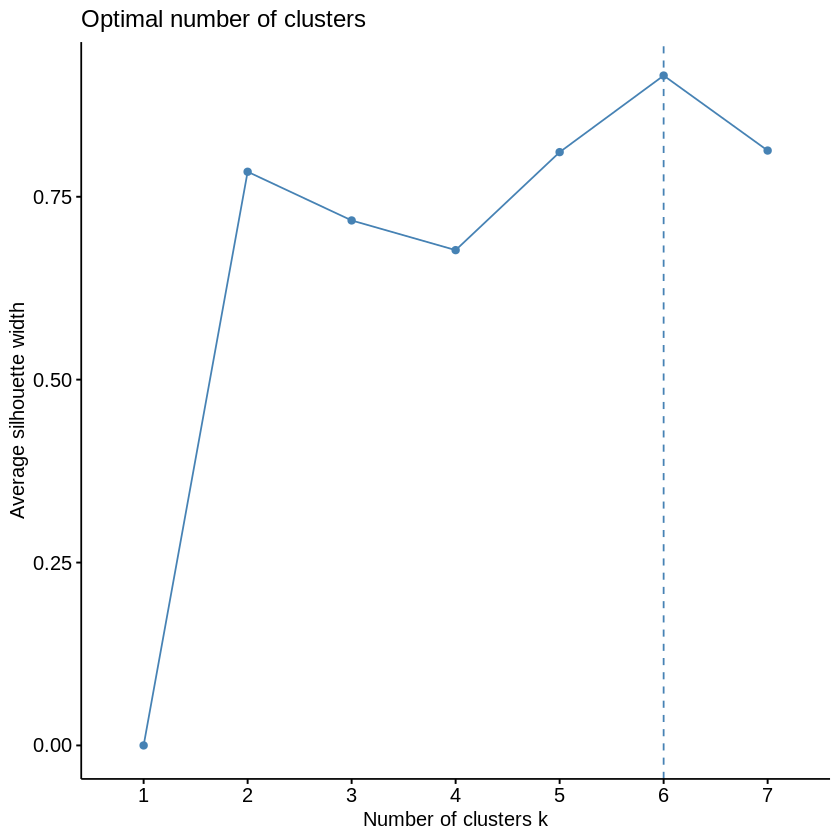

In [236]:
# Menentukan rentang jumlah cluster (k) yang akan diuji, dari 2 hingga 7
k_range <- 2:7

# Menghitung rata-rata lebar silhouette untuk setiap nilai k
avg_sil_widths <- sapply(k_range, function(k) { # Melakukan iterasi untuk setiap nilai k dalam k_range
  kmeans_result <- kmeans(df_rfm_all_scaled, centers = k,iter.max = 50) # Melakukan clustering k-means dengan k cluster
  sil <- silhouette(kmeans_result$cluster, dist(df_rfm_all_scaled)) # Menghitung silhouette score untuk setiap data point
  mean(sil[, 3]) # Menghitung rata-rata silhouette score untuk semua data point (kolom 3 dari objek silhouette)
})

# Menentukan jumlah cluster optimal (k) yang menghasilkan rata-rata lebar silhouette tertinggi
optimal_k <- k_range[which.max(avg_sil_widths)] # Mencari indeks k dengan nilai avg_sil_widths maksimum dan mengambil nilai k yang sesuai

# Membuat visualisasi untuk menentukan jumlah cluster optimal menggunakan metode silhouette
fviz_nbclust(df_rfm_all_scaled, kmeans, method = "silhouette",  # Menggunakan fungsi fviz_nbclust dari package factoextra
             k.max = 7)  # Menentukan jumlah maksimum cluster yang akan divisualisasikan (k.max = 7)

In [237]:
# Melakukan clustering K-means pada data RFM yang telah diskalakan
kmeans_result <- kmeans(df_rfm_all_scaled, centers = optimal_k,iter.max = 50)
# df_rfm_all_scaled: Data RFM yang telah diskalakan, digunakan sebagai input untuk clustering
# centers = optimal_k: Menentukan jumlah cluster yang digunakan dalam K-means, diambil dari nilai optimal_k yang telah dihitung sebelumnya

# Menampilkan hasil clustering K-means
kmeans_result
# Menampilkan objek kmeans_result yang berisi informasi tentang hasil clustering,
# seperti cluster setiap data point, centroid cluster, dan statistik lainnya.

K-means clustering with 6 clusters of sizes 97, 4, 3, 7, 19, 1

Cluster means:
  retention     freq monetary
1  4.000000 1.000000     1.00
2  4.000000 3.750000     2.25
3  4.000000 1.333333     2.00
4  4.000000 2.142857     1.00
5  2.473684 1.000000     1.00
6  4.000000 2.000000     4.00

Clustering vector:
  [1] 1 5 3 5 1 1 1 1 5 1 5 1 4 1 1 1 2 1 1 1 1 1 1 1 3 1 5 1 5 1 1 1 1 1 1 4 1
 [38] 1 5 1 1 1 1 1 1 1 1 5 1 1 4 1 1 1 1 1 5 1 5 1 1 1 1 1 2 2 5 1 4 1 1 1 1 1
 [75] 1 2 1 5 1 1 1 5 1 1 1 1 1 1 1 5 1 1 1 1 1 1 4 1 1 1 1 1 4 1 4 1 1 1 6 5 1
[112] 1 1 1 1 1 5 5 1 1 1 3 1 1 1 1 1 5 1 5 1

Within cluster sum of squares by cluster:
[1] 0.0000000 1.5000000 0.6666667 0.8571429 6.7368421 0.0000000
 (between_SS / total_SS =  90.5 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

__Discussion Time__

Berikan beberapa strategi untuk _cluster_ pelanggan yang terbentuk! Silakan gunakan data transaksi untuk mendukung strategi Anda!

In [241]:
# menambahkan informasi cluster pelanggan ke dalam data frame df_rfm
referensi           = df_rfm_all |> mutate(cluster_ke = kmeans_result$cluster) |> select(id_pelanggan,cluster_ke)
df_rfm_with_cluster = merge(df_rfm,referensi)